A lot of scratch work where I developed the DPSS smooth background subtraction and am working on incorporating an alternate ms model into SSINS.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from SSINS import INS
import os
import scipy.linalg as la
from scipy.signal import windows


In [18]:
##Defining two important functions -- the frequency channel selection and averaging functions.

def chan_select(ins, chan_name, shape_dict):

    """
    The frequency channel selection function. Also used to apply masks to your data.

    Args
    -----
    ins:
        INS object to be filtered.
    chan_name:
        channel name from shape dictionary
    shape_dict:
        shape dictionary by which you've divided and labelled the frequency array

    Returns
    -------
    ins_subband:
        INS object whose metric array is the filtered metric array without masks.
    masked_ins:
        INS object whose metric array is the filtered metric array with masks.
    N_bl:
        number of baselines.
    N_freq:
        number of frequencies.
    """

    #Creating band selection mask
    freq_mask = (ins.freq_array >= shape_dict[chan_name][0]) & (ins.freq_array <= shape_dict[chan_name][1])
    subband_chans = np.where(freq_mask)[0]
    N_freq = len(subband_chans)

    #Generating selected subband array
    ins_subband = ins.copy()
    ins_subband.select(freq_chans=subband_chans)
    N_bl = np.max(ins_subband.weights_array)

    #Masking
    masked_ins = ins_subband.copy()
    mask_array = ins_subband.mask_to_flags()[1:]
    masked_data = np.copy(ins_subband.metric_array)
    masked_data[mask_array] = np.nan
    masked_ins.metric_array = masked_data
    
    #Getting rid of the pesky subband lines
    line_mask = np.load('Data/linemask.npy')[subband_chans]
    ins_subband.metric_array = ins_subband.metric_array[:, ~line_mask, :]
    ins_subband.freq_array = ins_subband.freq_array[~line_mask]
    masked_ins.metric_array = masked_ins.metric_array[:, ~line_mask, :]
    masked_ins.freq_array = masked_ins.freq_array[~line_mask]

    return ins_subband, masked_ins, N_bl, N_freq


def chan_avg(ins):

    """
    The frequency channel averaging function. Averages the metric array over the frequency axis.

    Args
    ----
    ins:
        INS object to be averaged.

    Returns
    -------
    time_filtered:
        Clean time series.
    freq_averaged:
        Clean and frequency-averaged metric array.
    """
    
    #Calling time and amplitudes, filtering out infs and NaNs by mapping them to -1.
    time = np.array(ins.time_array)
    data = np.array(ins.metric_array[:, :, 0])
    data[~np.isfinite(data)] = -1

    #Averaging over full band/subband per integration
    freq_averaged = np.mean(data, axis=1)

    #Filtering out zeroes
    non_zero_mask = freq_averaged > 0
    time_filtered = time[non_zero_mask]
    freq_averaged = freq_averaged[non_zero_mask]

    return time_filtered, freq_averaged



In [19]:
##Importing INS datafile
data_dir = "Data"
night = "109276_p3"

datapath = os.path.join(data_dir, night + "_SSINS_data.h5")
maskpath = os.path.join(data_dir, night + "_SSINS_mask.h5")

ins = INS(datapath, telescope_name='MWA', mask_file=maskpath)

invalid value encountered in multiply
invalid value encountered in divide


In [20]:
##Importing prior coefficients

c0 = np.load('Data/p0_coefficients.npy')
c1 = np.load('Data/p1_coefficients.npy')
c2 = np.load('Data/p2_coefficients.npy')
c3 = np.load('Data/p3_coefficients.npy')
c4 = np.load('Data/p4_coefficients.npy')

coeffs = np.concatenate((c0, c1, c2, c3, c4))

In [21]:
##Defining the DTV shape dictionary
TV_dict = {
    'TV6': [1.74e8, 1.81e8],
    'TV7': [1.81e8, 1.88e8],
    'TV8': [1.88e8, 1.95e8],
    'TV9': [1.95e8, 2.02e8]
    }

##Selecting one DTV subband
chan_name = 'TV7'

##Extracting and averaging over the selected subband
ins_subband, masked_ins, N_bl, N_freq = chan_select(ins, chan_name, TV_dict)
time, amp = chan_avg(ins_subband)
masked_time, masked_amp = chan_avg(masked_ins)


sig_array has been reset


In [22]:
##Padding time arrays with NaNs
dt = st.mode(np.diff(masked_time)).mode
masked_smooth_time = np.arange(time.min(), time.max() + dt, dt)

dt = st.mode(np.diff(time)).mode
smooth_time = np.arange(time.min(), time.max() + dt, dt)

print('Time arrays padded.')


##Padding amplitude arrays with NaNs
masked_padded_amp = np.full_like(masked_smooth_time, np.nan, dtype=float)
masked_indices = np.searchsorted(masked_smooth_time, masked_time)
masked_padded_amp[masked_indices] = masked_amp

padded_amp = np.full_like(smooth_time, np.nan, dtype=float)
indices = np.searchsorted(smooth_time, time)
padded_amp[indices] = amp

print('Amplitude arrays padded.')


Time arrays padded.
Amplitude arrays padded.


invalid value encountered in sqrt


Design matrix generated.


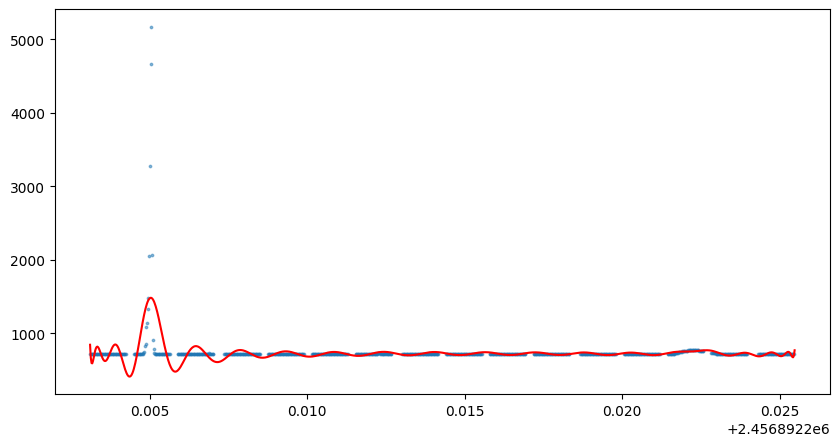

In [23]:
padded_amp_filt = padded_amp[smooth_time > np.median(smooth_time)]
smooth_time_filt = smooth_time[smooth_time > np.median(smooth_time)]

##Generate DPSS design matrix
design = windows.dpss(M=len(smooth_time), NW=8, Kmax=40, return_ratios=True)[0].T
print('Design matrix generated.')

##Constructing DPSS least squares fit
observed_indices = ~np.isnan(padded_amp)
splice_design = design[observed_indices, :]
coefficients = la.solve(splice_design.T @ splice_design, splice_design.T @ padded_amp[observed_indices])
fit = design @ coefficients

#Finding the noise covariance
mu = splice_design @ coefficients
C = 4/np.pi-1
noise_cov = np.diag((fit ** 2) * C / (N_bl * N_freq))
splice_noise_cov = np.diag((mu ** 2) * C / (N_bl * N_freq))

#Finding the parameter covariance
sigma_p = la.solve(splice_design.T @ la.solve(splice_noise_cov, splice_design), np.eye(splice_design.shape[1]))

#Finding the fit covariance
sigma_f = design @ sigma_p @ design.T

noise_err = np.diag(np.sqrt(noise_cov))
fit_err = np.diag(np.sqrt(sigma_f))

plt.figure(figsize=(10, 5))
plt.scatter(time, amp, alpha=0.5, s=3)
plt.plot(np.sort(smooth_time), fit, color='red')
plt.fill_between(smooth_time, fit - noise_err, fit + noise_err, alpha = 0.5)

plt.show()

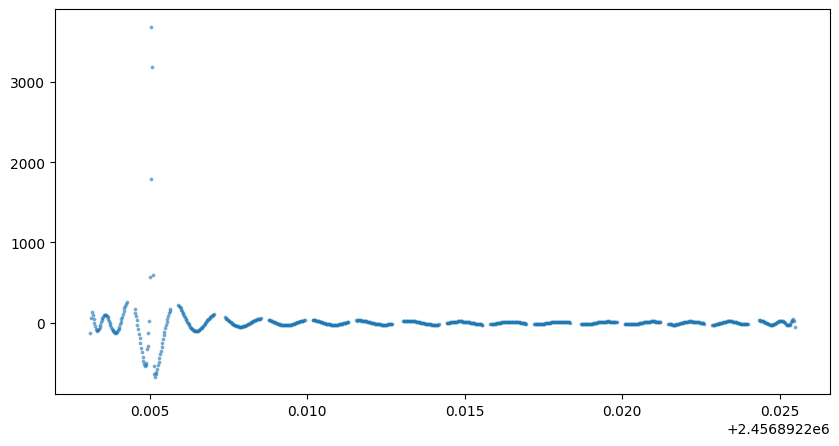

In [24]:
plt.figure(figsize=(10, 5))
residuals = padded_amp - fit
plt.scatter(smooth_time, residuals, s=3, alpha=0.5)

In [25]:
#Calculating covariances

def cov_calc(design, masked_padded_amp, N_bl, N_freq):

    observed_indices = ~np.isnan(masked_padded_amp)
    splice_design = design[observed_indices, :]
    print(splice_design.shape)
    print(design.shape)

    K = la.inv(splice_design.T @ splice_design) @ splice_design.T
    
    coeffs = K @ masked_padded_amp[observed_indices]

    #This is mu hat
    fit = design @ coeffs
    mu = splice_design @ coeffs

    #Now to calculate noise covariance
    C = 4/np.pi-1
    noise_cov = np.diag((fit ** 2) * C / (N_bl * N_freq))
    splice_noise_cov = np.diag((mu ** 2) * C / (N_bl * N_freq))

    #Finding the parameter covariance
    sigma_p = la.inv(splice_design.T @ la.inv(splice_noise_cov) @ splice_design)

    #Finding the fit covariance
    sigma_f = design @ sigma_p @ design.T

    return noise_cov, sigma_p, sigma_f

noise_cov, sigma_p, sigma_f = cov_calc(design, masked_padded_amp, N_bl, N_freq)

noise_err = np.sqrt(np.diag(noise_cov))
fit_err = np.sqrt(np.diag(sigma_f))

(681, 40)
(967, 40)


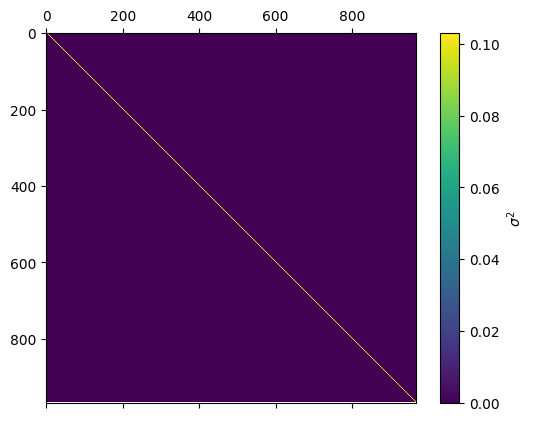

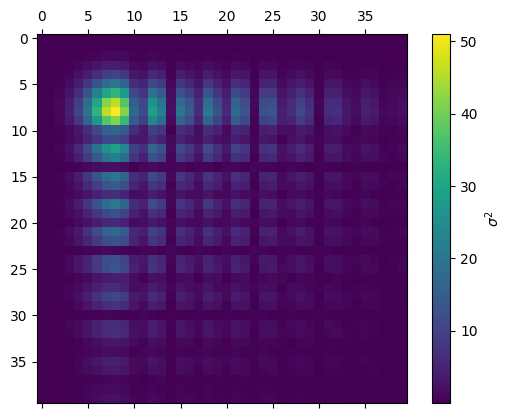

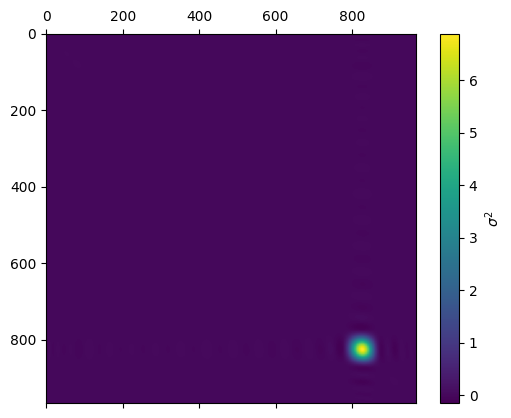

In [31]:
#Constructing covariance plots

def cov_plots():
    
    #For noise covariance
    fig, ax = plt.subplots()
    im = ax.matshow(noise_cov)
    fig.colorbar(im, ax=ax, label=r'$\sigma^2$')
    plt.show()

    #For parameter covariance
    fig, ax = plt.subplots()
    im = ax.matshow(np.abs(sigma_p))
    fig.colorbar(im, ax=ax, label=r'$\sigma^2$')
    plt.show()

    #For fit covariance
    fig, ax = plt.subplots()
    im = ax.matshow(sigma_f)
    fig.colorbar(im, ax=ax, label=r'$\sigma^2$')
    plt.show()

cov_plots()

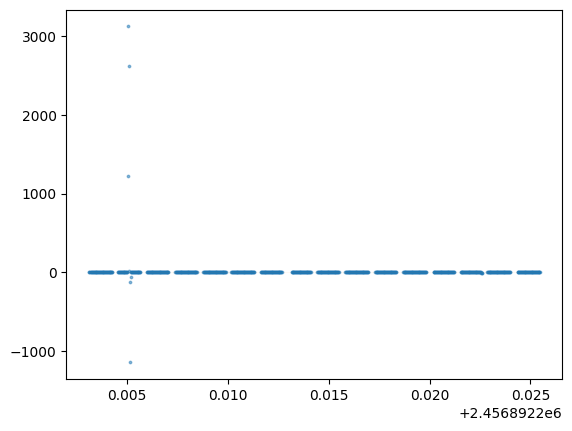

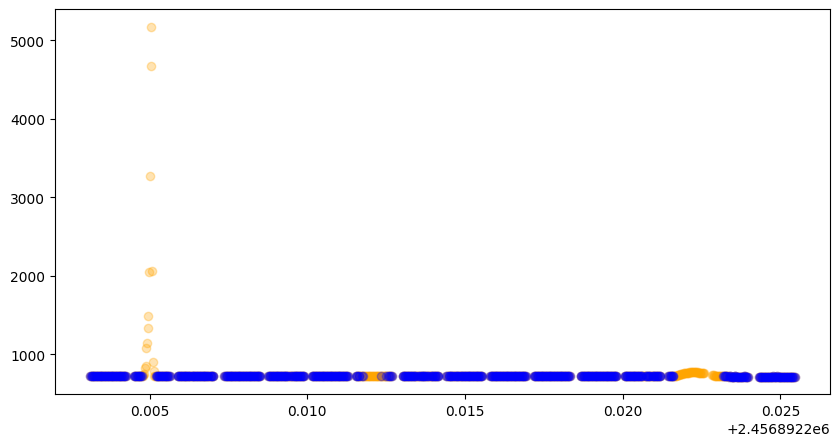

In [ ]:
#Testing sliding window median subtraction -- WIP

from scipy.ndimage import median_filter

local_amp = median_filter(padded_amp, size=10, mode='nearest')
clippings = padded_amp - local_amp

plt.scatter(smooth_time, clippings, s=3, alpha=0.5)
plt.fill_between(smooth_time, -5*noise_err, 5*noise_err, alpha=0.2)
plt.show()

wind_size = 50

sig_thresh = 5

filt_amps = np.copy(amp)

C = 4/np.pi-1

for i in np.arange(wind_size, filt_amps.shape[0]):
    med = np.median(filt_amps[i - wind_size: i][~np.isnan(filt_amps[i - wind_size: i])])
    noise = np.sqrt((med ** 2) * C / (N_bl * N_freq))
    filt_amps[i - wind_size: i] = np.where(filt_amps[i - wind_size: i] > np.abs(med + sig_thresh*noise), np.nan, filt_amps[i - wind_size: i])

mask = np.where(np.isnan(filt_amps), False, True)


plt.figure(figsize=(10, 5))
plt.scatter(time, amp, alpha=0.3, color='orange')
plt.scatter(time, filt_amps, alpha=0.3, color='blue')
plt.show()
